# Fitting single PSFs in 3D

* Simulated 3D PSF based on Fourier optics model with aberations
* CNN-based encoder to extract x, y, z, amplitude, background,
* The model also learns the pupil plane phase image
* Rendered back into images based on Fourier optics model

In [1]:
import os
import numpy as np
from matplotlib import pyplot

import torch
from torch import nn
from torch.utils.data import DataLoader

from torchinfo import summary

from smlm_dl import dataset, model, trainer, config, util

/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/dataset.py:441: RuntimeWarning: invalid value encountered in log
  im = axes[1].imshow(np.log(tiled_images))


8078:	 [id = 8078.000,], [A = 1778.318,], [bg = 48.184,], [x = -7.085,], [y = 7.926,], [z = 0.971,],
5276:	 [id = 5276.000,], [A = 2542.504,], [bg = 91.286,], [x = 7.022,], [y = 4.377,], [z = 4.421,],
5877:	 [id = 5877.000,], [A = 2882.135,], [bg = 57.272,], [x = -6.784,], [y = 7.667,], [z = 2.829,],
4918:	 [id = 4918.000,], [A = 2092.196,], [bg = 28.218,], [x = -6.079,], [y = 4.952,], [z = 1.820,],
2858:	 [id = 2858.000,], [A = 2514.781,], [bg = 87.090,], [x = 0.797,], [y = -11.802,], [z = -0.181,],
5393:	 [id = 5393.000,], [A = 1165.673,], [bg = 62.042,], [x = -8.079,], [y = -5.331,], [z = -0.009,],
5749:	 [id = 5749.000,], [A = 1106.963,], [bg = 82.074,], [x = -10.846,], [y = 8.953,], [z = 4.760,],
3527:	 [id = 3527.000,], [A = 1165.441,], [bg = 42.417,], [x = 9.826,], [y = 5.735,], [z = -0.972,],
1736:	 [id = 1736.000,], [A = 2993.884,], [bg = 8.077,], [x = -5.502,], [y = 2.373,], [z = -0.633,],
362:	 [id = 362.000,], [A = 2280.338,], [bg = 42.387,], [x = -9.120,], [y = 10.610,], [

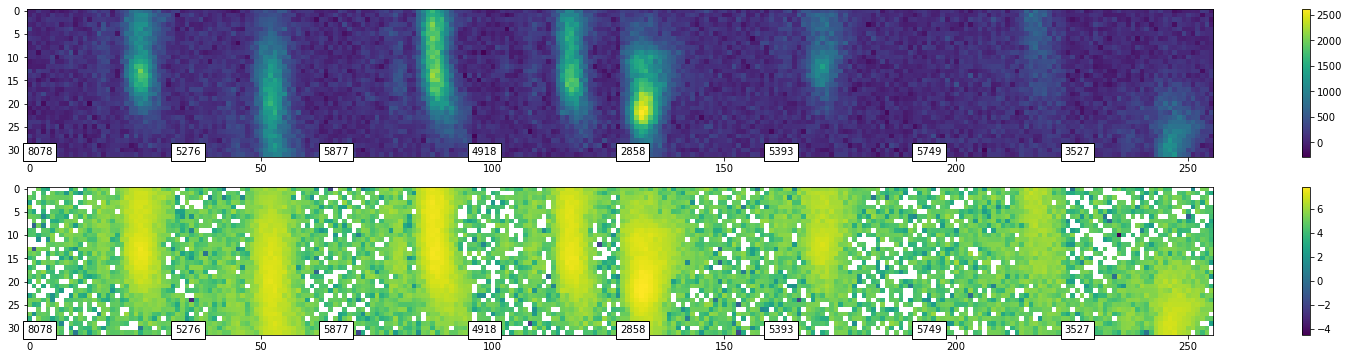

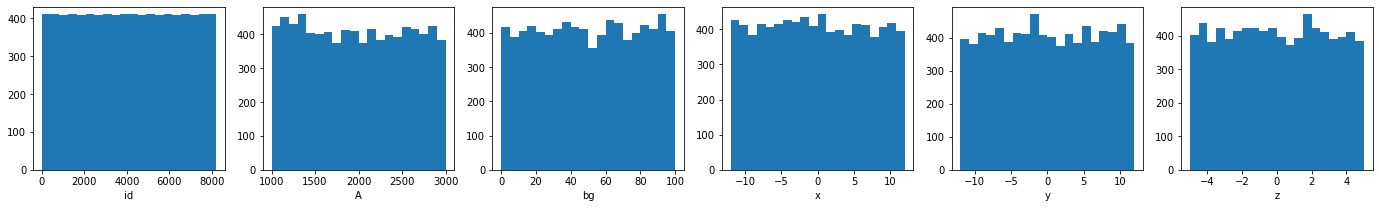

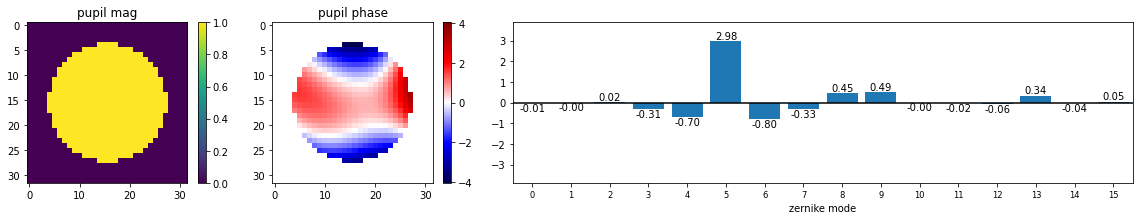

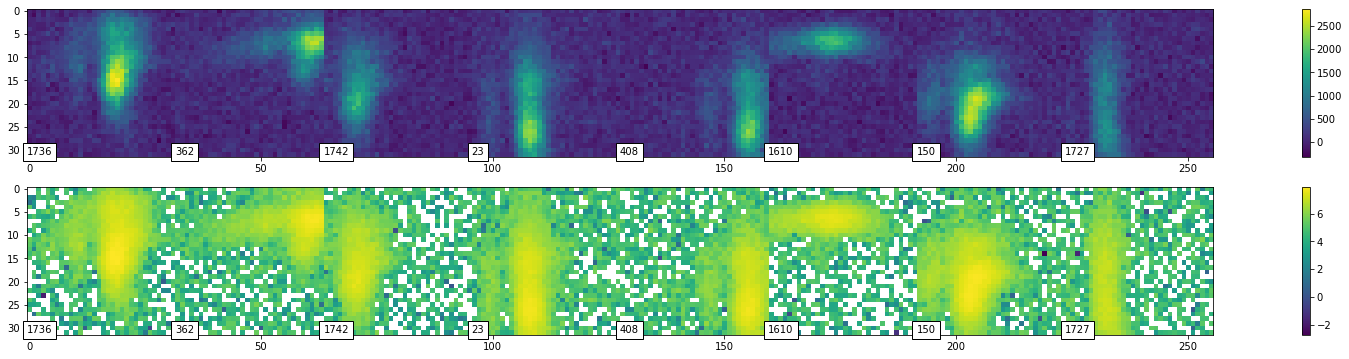

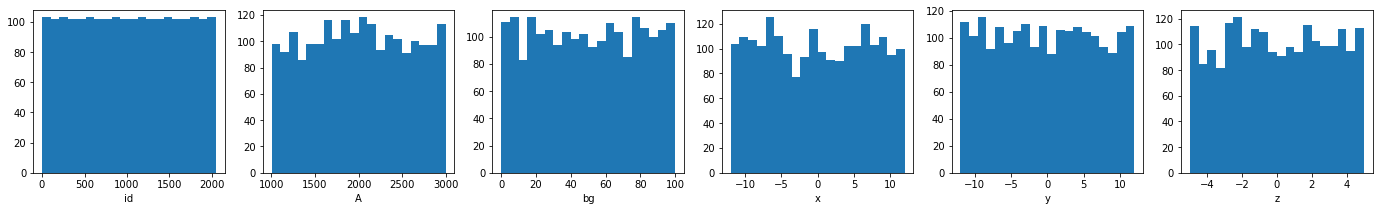

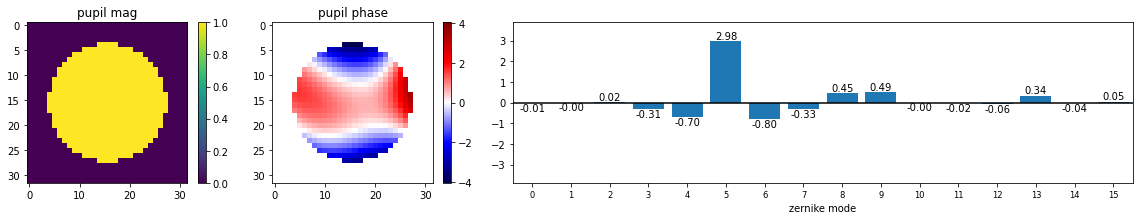

In [2]:
settings = {
    'out_size': (32,32),
    'length': (8192, 1),
    'psf_params': {'A': [1000, 3000],
                   'bg': [0, 100],
                   'x': [-12, 12],
                   'y': [-12, 12],
                   'z': [-5, 5]
                  },
    'psf_zerns': {key: np.random.uniform(-1,1) for key in range(3, 10)},
}
settings['psf_zerns'][5] = np.random.uniform(1, 3) # astigmatic 3D

training_data = dataset.FourierOpticsPSFDataset(**settings)
training_data.to('cuda')
dataset.inspect_images(training_data)
train_dataloader = DataLoader(training_data, batch_size=2048, shuffle=True, )

settings['length'] = (2048)
validation_data = dataset.FourierOpticsPSFDataset(**settings)
validation_data.to('cuda')
dataset.inspect_images(validation_data)
validation_dataloader = DataLoader(validation_data, batch_size=2048, shuffle=True, )

In [3]:
fitting_model = model.FourierOptics2DModel(fit_params=['x','y','A','bg','z'],
                                           encoder_params={"depth":4, },
                                           renderer_params={"pupil_params":{'scale':0.75, 'apod':False,
                                                                            'remove_tilt_tip_defocus':False, 'phase_init_zern': {5: 2}, }},
                                          )
print(summary(fitting_model, depth=4))

Layer (type:depth-idx)                   Param #
FourierOptics2DModel                     --
├─DirectMapperModel: 1-1                 --
│    └─ModuleDict: 2-1                   --
├─FourierOptics2DRenderer: 1-2           --
│    └─Sequential: 2-2                   --
│    │    └─ParameterModule: 3-1         1,024
├─ConvImageEncoderModel: 1-3             --
│    └─ModuleDict: 2-3                   --
│    │    └─Sequential: 3-2              --
│    │    │    └─Conv2d: 4-1             320
│    │    │    └─ReLU: 4-2               --
│    │    │    └─Conv2d: 4-3             9,248
│    │    │    └─ReLU: 4-4               --
│    │    │    └─MaxPool2d: 4-5          --
│    │    └─Sequential: 3-3              --
│    │    │    └─Conv2d: 4-6             18,496
│    │    │    └─ReLU: 4-7               --
│    │    │    └─Conv2d: 4-8             36,928
│    │    │    └─ReLU: 4-9               --
│    │    │    └─MaxPool2d: 4-10         --
│    │    └─Sequential: 3-4              --
│    │    │ 

Device: cuda
Saved model to : /home/kkc29/scratch60/runs/2022-04-29_15-54-15_c18n07.farnam.hpc.yale.internal/model.ptm
Saved loss model : /home/kkc29/scratch60/runs/2022-04-29_15-54-15_c18n07.farnam.hpc.yale.internal/loss.ptm


  0%|          | 0/1000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 999. Saved to : /home/kkc29/scratch60/runs/2022-04-29_15-54-15_c18n07.farnam.hpc.yale.internal/checkpoint.ptc
input shape: (2048, 1, 32, 32), output_shape: (2048, 1, 32, 32)


/gpfs/ysm/home/kkc29/repos/smlm-dl/smlm_dl/model/base.py:151: RuntimeWarning: invalid value encountered in log10
  im = axes[0, i].imshow(np.log10(img))


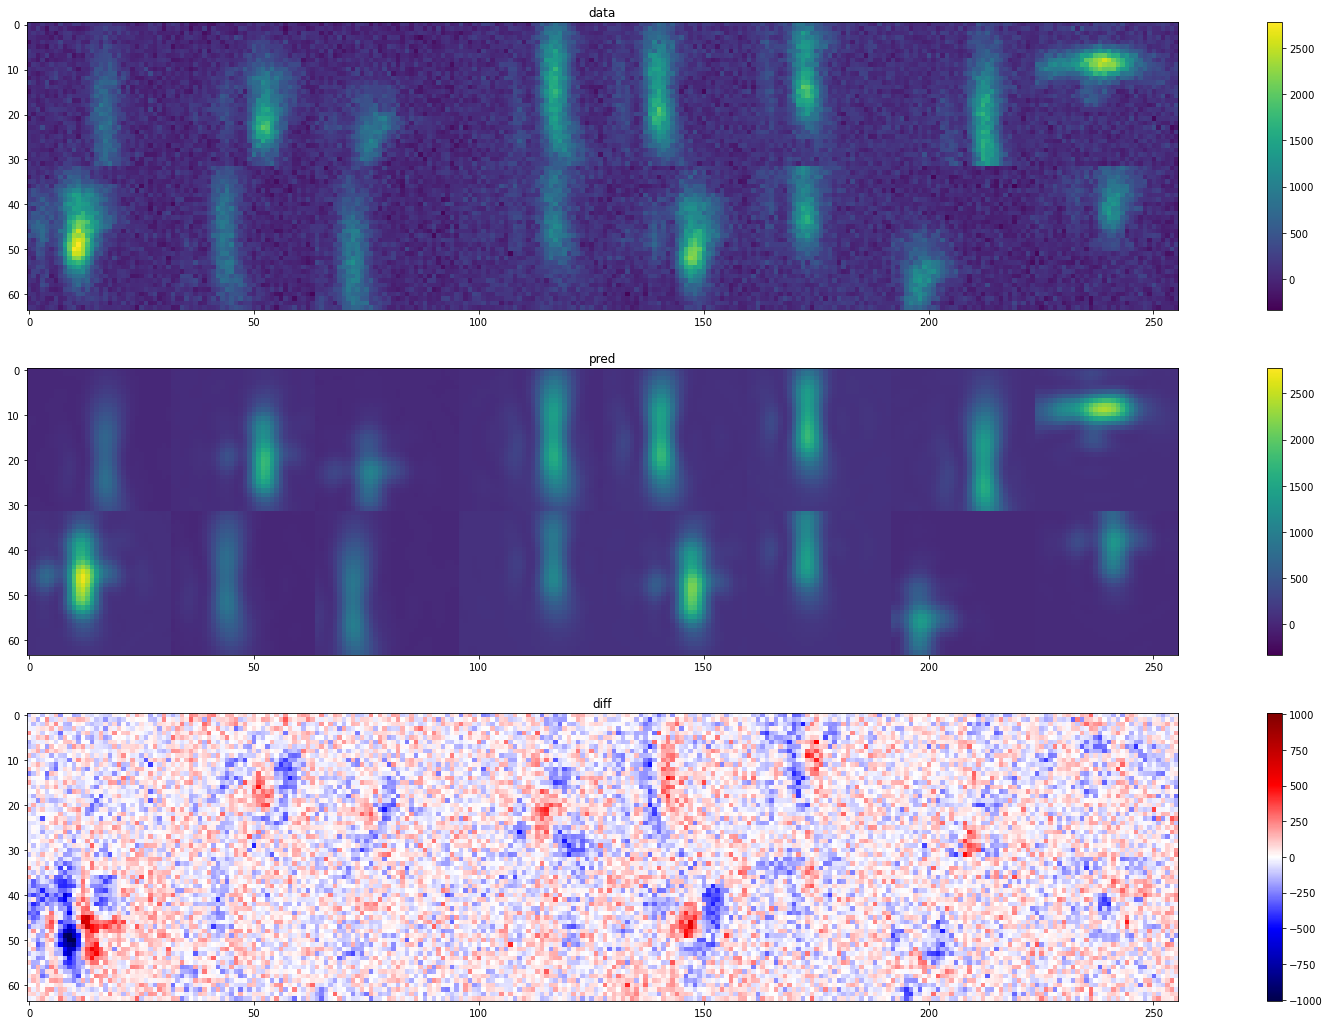

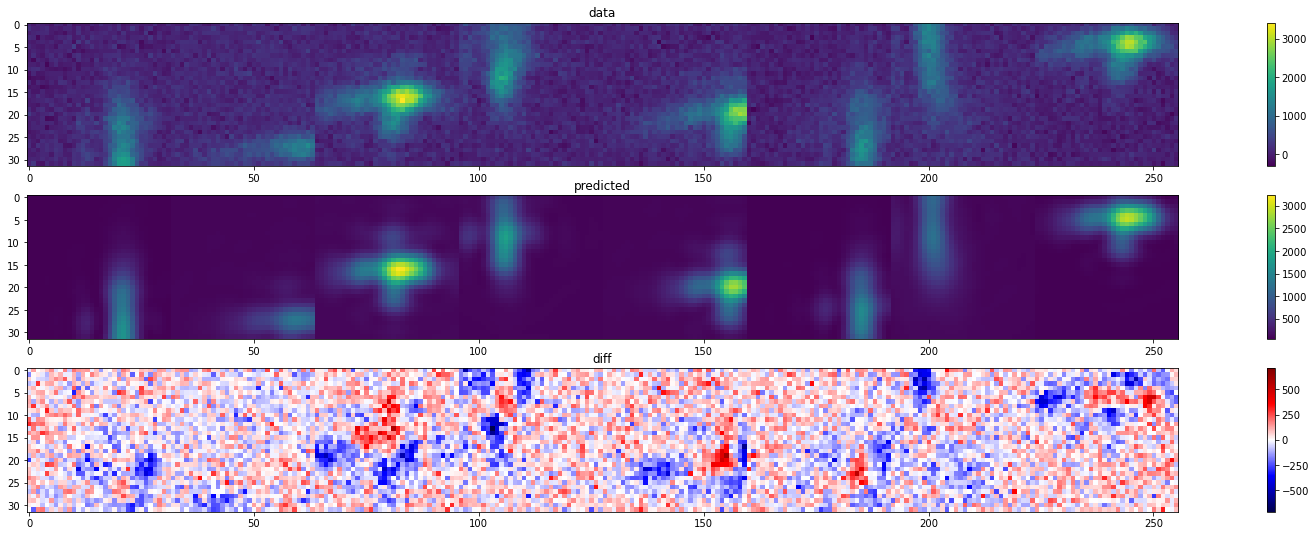

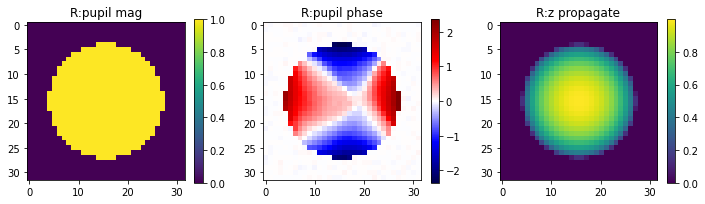

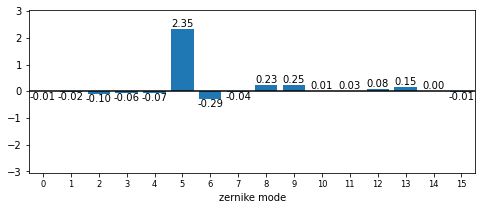

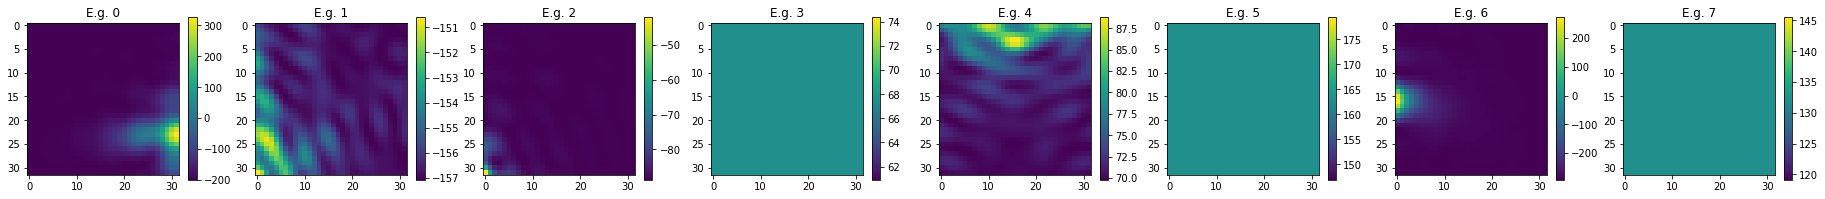

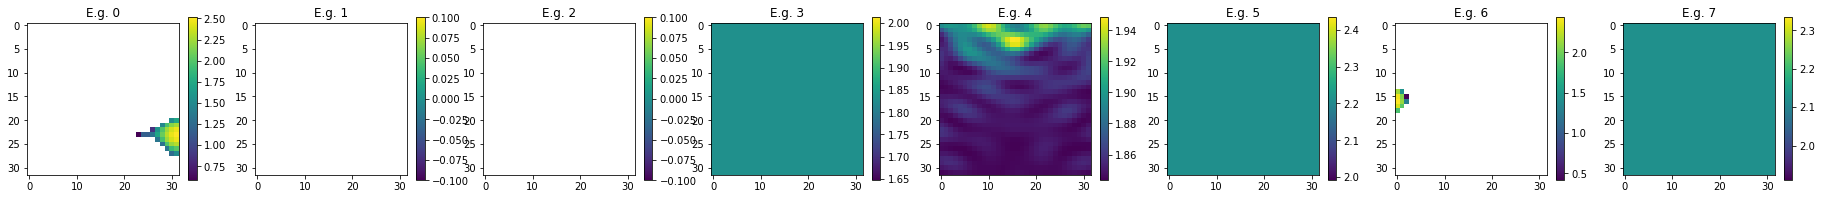

In [4]:
dict_log = {}
training = trainer.FittingTrainer(fitting_model, train_dataloader, validation_dataloader, optimizer=torch.optim.AdamW(fitting_model.parameters(), lr=1e-4))
training.train_and_validate(1000, 10, 100, tb_logger=True, dict_log=dict_log)
model.check_model(fitting_model, train_dataloader)

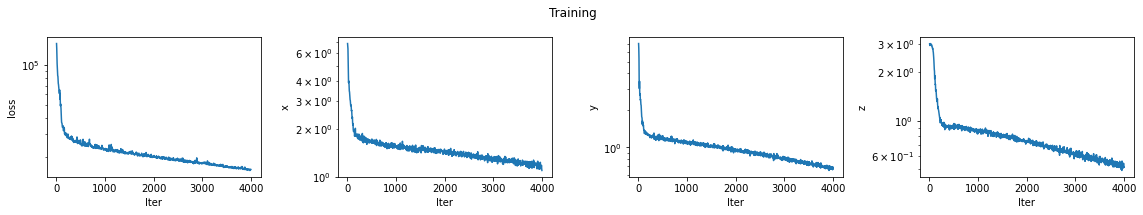

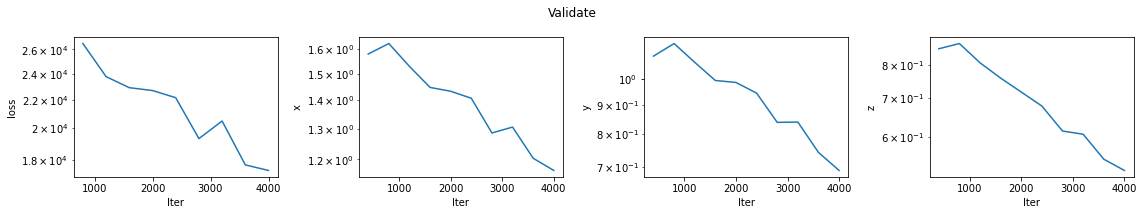

In [7]:
plots = trainer.inspect_dict_log(dict_log, log=True)